# Is the Golden Leaf Still Profitable: Analyzing the Impact of Weather and Inflation on Zimbabwe’s Tobacco Market (2022–2025)

**Author:** Priscillah C & Philipa M 
**Date:** July 2025

## Project Goals
- Analyze how rainfall and inflation affect tobacco sales and prices in Zimbabwe.
- Quantify their impacts and build time series/regression models for insight and forecasting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for time series/regression:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import plotly.express as px

# For date handling:
from datetime import datetime


In [2]:
# loading our datasets
sales_df = pd.read_csv("tobacco_sales_data.csv", delimiter =';')
rainfall_df = pd.read_csv("rainfall_zimbabwe_annual.csv")
inflation_df = pd.read_excel("inflation.xlsx")

# Quick previews
print(sales_df.head())
print(rainfall_df.head())
print(inflation_df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'tobacco_sales_data.csv'

In [ ]:
import pandas as pd

# Load datasets
sales_df = pd.read_csv("tobacco_sales_data.csv", delimiter=';')
rainfall_df = pd.read_csv("rainfall_zimbabwe_annual.csv")
inflation_df = pd.read_excel("inflation.xlsx")

# --- Clean sales_df ---
# Convert date to datetime
sales_df["date"] = pd.to_datetime(sales_df["date"], errors="coerce")

# Extract year (to merge later)
sales_df["year"] = sales_df["date"].dt.year

# --- Clean rainfall_df ---
rainfall_df = rainfall_df.rename(columns={"season_year": "year"})  # rename to match
rainfall_df["year"] = rainfall_df["year"].astype(int)

# --- Clean inflation_df ---
inflation_df["year"] = inflation_df["year"].astype(int)

# --- Merge everything ---
merged_df = (
    sales_df
    .merge(rainfall_df, on="year", how="left")
    .merge(inflation_df, on="year", how="left")
)

# Preview merged dataset
print(merged_df.head(10))


        date  year  day_number  auction_weight_kg  auction_price_usd  \
0 2025-07-22  2025          96           19507119               3.57   
1 2025-07-21  2025          95           19467767               3.57   
2 2025-07-18  2025          94           19427361               3.57   
3 2025-07-17  2025          93           19397720               3.58   
4 2025-07-16  2025          92           19328162               3.58   
5 2025-07-15  2025          91           19238128               3.59   
6 2025-07-14  2025          90           19136319               3.61   
7 2025-07-11  2025          89           19041953               3.60   
8 2025-07-10  2025          88           18957334               3.60   
9 2025-07-09  2025          87           18825426               3.61   

   contract_weight_kg  contract_price_usd  combined_weight_kg  \
0         328566854.0                3.31         348073973.0   
1         328263865.0                3.31         347731632.0   
2         32

In [ ]:
print(merged_df.tail(10))


          date  year  day_number  auction_weight_kg  auction_price_usd  \
365 2022-05-20  2022          35            6873274               3.13   
366 2022-05-19  2022          34            6752185               3.12   
367 2022-05-17  2022          32            6278500               3.11   
368 2022-05-16  2022          31            6012416               3.10   
369 2022-05-13  2022          30            5837475               3.15   
370 2022-05-12  2022          29            5753382               3.15   
371 2022-05-11  2022          28            5546180               3.15   
372 2022-05-10  2022          27            5272017               3.15   
373 2022-05-09  2022          26            5007237               3.15   
374 2022-05-06  2022          25            4742300               3.15   

     contract_weight_kg  contract_price_usd  combined_weight_kg  \
365          92494231.0                2.97          99367505.0   
366          89894625.0                2.97        

In [ ]:
# --- Step 1: Dataset Information & Missing Values ---

print("=== Sales Data ===")
print(sales_df.info())   # column types + non-null counts
print(sales_df.describe(include="all"))  # summary stats
print("\nMissing values per column in sales data:\n", sales_df.isnull().sum())

print("\n=== Rainfall Data ===")
print(rainfall_df.info())
print(rainfall_df.describe(include="all"))
print("\nMissing values per column in rainfall data:\n", rainfall_df.isnull().sum())

print("\n=== Inflation Data ===")
print(inflation_df.info())
print(inflation_df.describe(include="all"))
print("\nMissing values per column in inflation data:\n", inflation_df.isnull().sum())


=== Sales Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      375 non-null    datetime64[ns]
 1   year                      375 non-null    int32         
 2   day_number                375 non-null    int64         
 3   auction_weight_kg         375 non-null    int64         
 4   auction_price_usd         375 non-null    float64       
 5   contract_weight_kg        375 non-null    float64       
 6   contract_price_usd        375 non-null    float64       
 7   combined_weight_kg        375 non-null    float64       
 8   combined_price_usd        375 non-null    float64       
 9   rejection_rate_auction    375 non-null    float64       
 10  rejection_rate_contract   375 non-null    float64       
 11  month                     375 non-null    int64         
 12  wee

**EXPLORATORY DATA ANALYSIS**

*Sales and Price Dynamics*

Tobacco is Zimbabwe’s most valuable agricultural export, and understanding its sales volumes and price dynamics is crucial for evaluating profitability. In this step, we will:

**Examine annual trends in sales volumes**

- How much tobacco is being sold each year (auction vs. contract).

- Detect whether production is increasing, stable, or declining.

**Analyze tobacco price movements**

- Track average auction and contract prices per kg over time.

- Identify whether prices are volatile or follow a steady trend.

**Compare sales vs. price interactions**

- Do higher sales volumes lead to lower prices (oversupply effect)?

- Are prices resilient during years of low production?

**Visualize sales and price trends**

- Use line and bar charts to highlight dynamics between 2015–2025.

- Show both annual sales weight (kg) and average prices (USD/kg).

This step establishes the core market trends for Zimbabwe’s tobacco sector before we layer in the impact of climate (rainfall) and economic conditions (inflation).

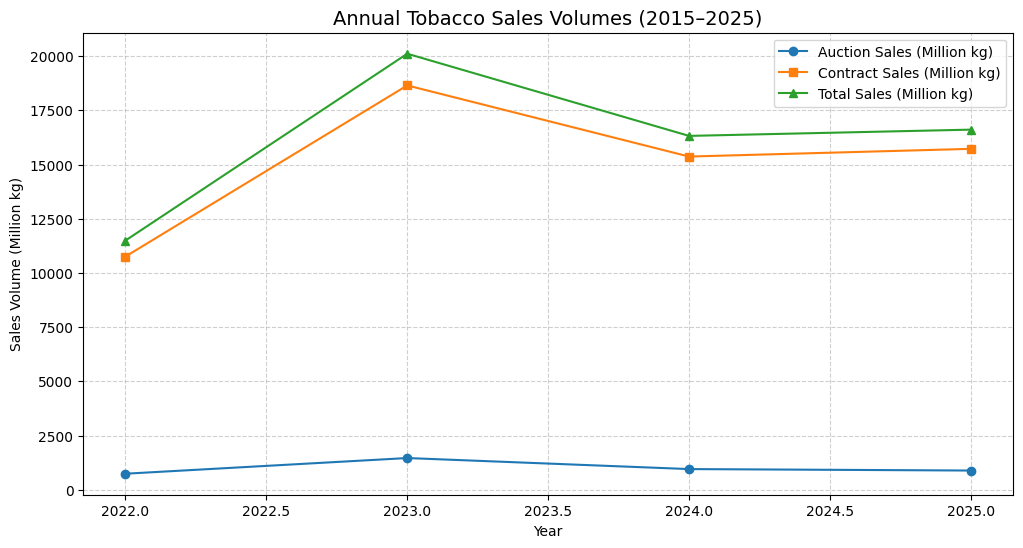

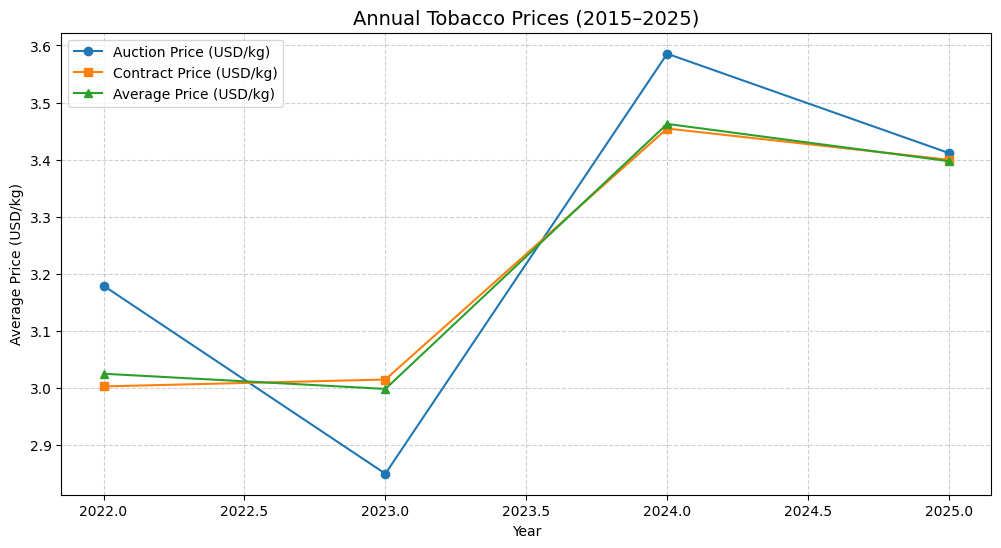

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Aggregate sales data annually ---
annual_sales = sales_df.groupby("year").agg({
    "auction_weight_kg": "sum",
    "contract_weight_kg": "sum",
    "combined_weight_kg": "sum",
    "auction_price_usd": "mean",
    "contract_price_usd": "mean",
    "combined_price_usd": "mean"
}).reset_index()

# --- Plot Sales Volumes (Auction vs Contract vs Combined) ---
plt.figure(figsize=(12,6))
plt.plot(annual_sales["year"], annual_sales["auction_weight_kg"]/1e6, label="Auction Sales (Million kg)", marker="o")
plt.plot(annual_sales["year"], annual_sales["contract_weight_kg"]/1e6, label="Contract Sales (Million kg)", marker="s")
plt.plot(annual_sales["year"], annual_sales["combined_weight_kg"]/1e6, label="Total Sales (Million kg)", marker="^")

plt.title("Annual Tobacco Sales Volumes (2015–2025)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Sales Volume (Million kg)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Plot Average Prices (Auction vs Contract vs Combined) ---
plt.figure(figsize=(12,6))
plt.plot(annual_sales["year"], annual_sales["auction_price_usd"], label="Auction Price (USD/kg)", marker="o")
plt.plot(annual_sales["year"], annual_sales["contract_price_usd"], label="Contract Price (USD/kg)", marker="s")
plt.plot(annual_sales["year"], annual_sales["combined_price_usd"], label="Average Price (USD/kg)", marker="^")

plt.title("Annual Tobacco Prices (2015–2025)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Price (USD/kg)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


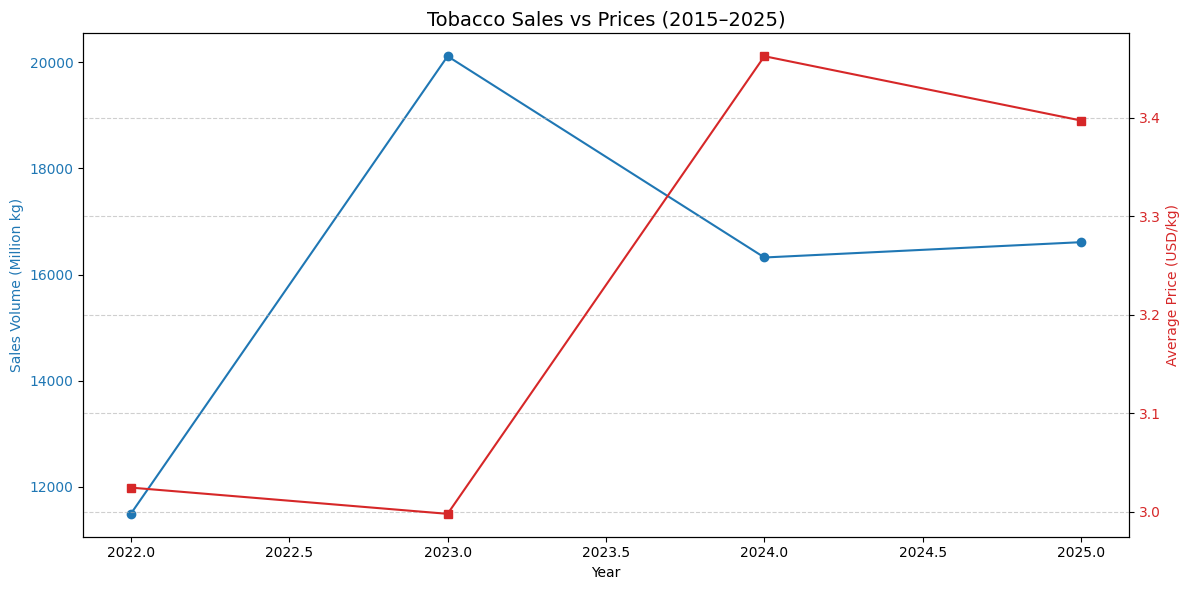

In [ ]:
# --- Dual Axis Plot: Total Sales vs Average Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Left axis → Sales Volume
ax1.plot(annual_sales["year"], annual_sales["combined_weight_kg"]/1e6, 
         color="tab:blue", marker="o", label="Total Sales (Million kg)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Sales Volume (Million kg)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right axis → Price
ax2 = ax1.twinx()
ax2.plot(annual_sales["year"], annual_sales["combined_price_usd"], 
         color="tab:red", marker="s", label="Average Price (USD/kg)")
ax2.set_ylabel("Average Price (USD/kg)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Titles & grid
plt.title("Tobacco Sales vs Prices (2015–2025)", fontsize=14)
fig.tight_layout()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


*If sales rise but prices fall, it shows oversupply/market saturation.*

*If both sales and prices rise, it suggests strong demand resilience.*

*If sales drop but prices rise, farmers may still remain profitable.*

In [ ]:
# --- Correlation between sales and price ---
corr = annual_sales["combined_weight_kg"].corr(annual_sales["combined_price_usd"])

print(f"Correlation between sales volume and price: {corr:.2f}")


Correlation between sales volume and price: 0.06


**Interpretation**

- Close to +1 → Sales and prices move together (demand-driven).

- Close to -1 → Sales and prices move in opposite directions (oversupply effect).

- Around 0 → Weak or no clear relationship (external shocks like policy or weather dominate).

  *Since our correlation between sales volume and price is 0.06  it basically means :*

  - Sales volume and average price in Zimbabwe’s tobacco market are not strongly linked.

  - This suggests that other forces (like inflation shocks, rainfall variability, government policy, or global demand) are driving price changes rather than just the volume of tobacco sold.

In short → selling more doesn’t necessarily lower the price, and low sales don’t necessarily raise it.

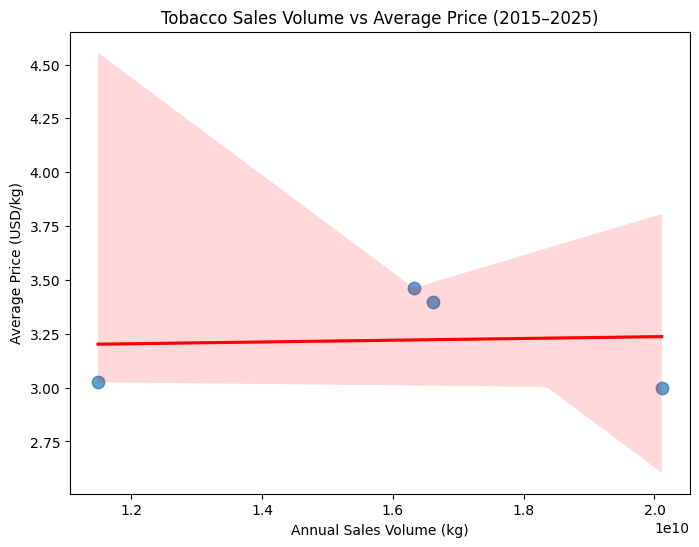

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.regplot(
    data=annual_sales,
    x="combined_weight_kg", 
    y="combined_price_usd", 
    scatter_kws={"s":80, "alpha":0.7}, 
    line_kws={"color":"red"}
)
plt.title("Tobacco Sales Volume vs Average Price (2015–2025)")
plt.xlabel("Annual Sales Volume (kg)")
plt.ylabel("Average Price (USD/kg)")
plt.show()


Correlation between yearly % change in sales and price: -0.63


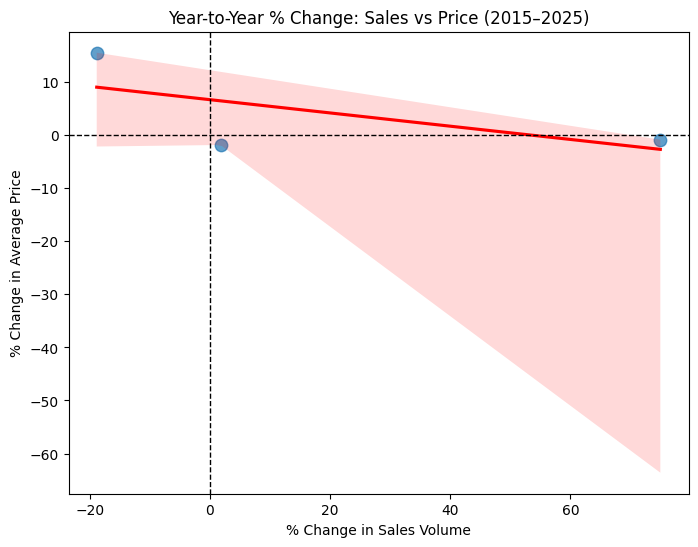

In [ ]:
# Yearly percentage changes
annual_sales["pct_change_sales"] = annual_sales["combined_weight_kg"].pct_change() * 100
annual_sales["pct_change_price"] = annual_sales["combined_price_usd"].pct_change() * 100

# Drop the first NaN row (since pct_change has no previous year for 2015)
annual_changes = annual_sales.dropna()

# Correlation between yearly changes
corr_changes = annual_changes["pct_change_sales"].corr(annual_changes["pct_change_price"])
print("Correlation between yearly % change in sales and price:", round(corr_changes, 2))

# Plot scatter with regression line
plt.figure(figsize=(8,6))
sns.regplot(
    data=annual_changes,
    x="pct_change_sales", 
    y="pct_change_price",
    scatter_kws={"s":80, "alpha":0.7},
    line_kws={"color":"red"}
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Year-to-Year % Change: Sales vs Price (2015–2025)")
plt.xlabel("% Change in Sales Volume")
plt.ylabel("% Change in Average Price")
plt.show()


So while the raw correlation (0.06) suggested almost no relationship, the year-to-year percentage changes reveal a strong negative correlation (-0.63).

**This means:**

- When sales volumes spike, prices usually drop the next year (likely due to oversupply).

- When sales volumes fall, prices tend to rise (scarcity effect).

This is a classic supply–demand dynamic in agricultural market

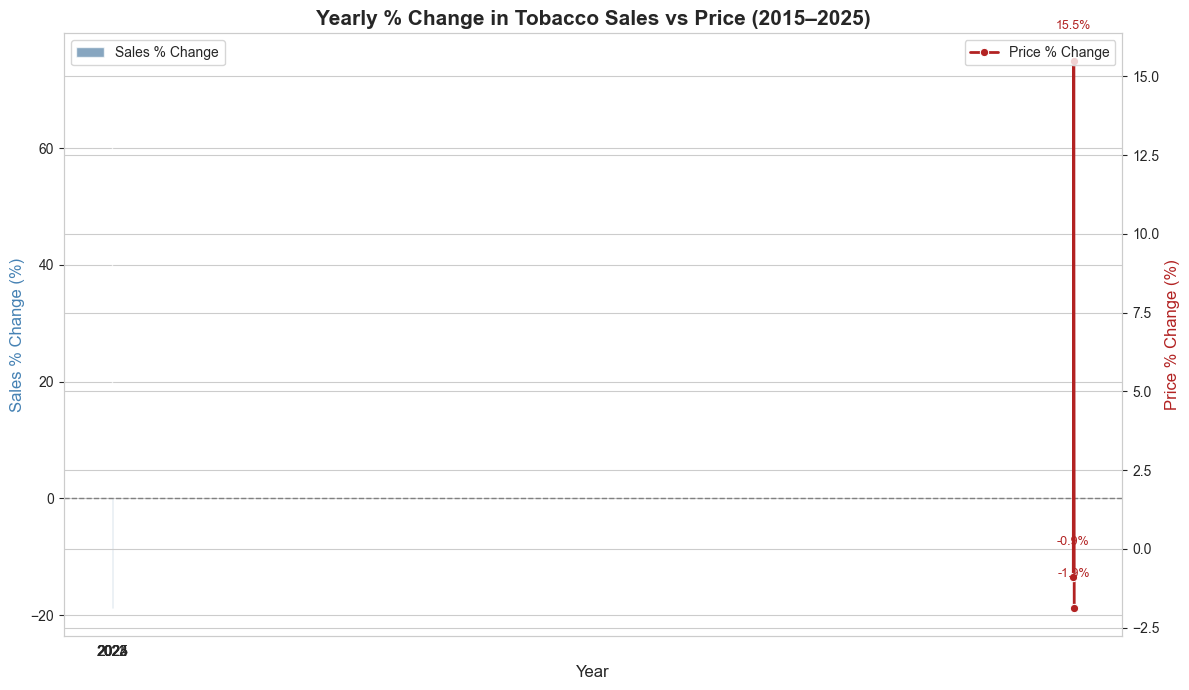

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate yearly totals and averages
annual_sales = sales_df.groupby("year")["combined_weight_kg"].sum()
annual_price = sales_df.groupby("year")["combined_price_usd"].mean()

# Compute year-on-year % change
sales_pct = annual_sales.pct_change() * 100
price_pct = annual_price.pct_change() * 100

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))

# Plot sales % change (bars)
ax = sns.barplot(x=sales_pct.index, y=sales_pct.values, 
                 color="steelblue", alpha=0.7, label="Sales % Change")

# Create a second axis for prices
ax2 = ax.twinx()
sns.lineplot(x=price_pct.index, y=price_pct.values, 
             color="firebrick", marker="o", linewidth=2, label="Price % Change", ax=ax2)

# Axis labels
ax.set_ylabel("Sales % Change (%)", fontsize=12, color="steelblue")
ax2.set_ylabel("Price % Change (%)", fontsize=12, color="firebrick")
ax.set_xlabel("Year", fontsize=12)

# Titles
plt.title("Yearly % Change in Tobacco Sales vs Price (2015–2025)", fontsize=15, weight="bold")

# Add a zero line
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

# Annotate price points
for x, y in zip(price_pct.index, price_pct.values):
    ax2.text(x, y+1, f"{y:.1f}%", ha="center", fontsize=9, color="firebrick")

# Legends
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


*Climate Impact (Rainfall)*
Objective

We want to investigate how rainfall patterns (2015–2025) have influenced tobacco production volumes and prices in Zimbabwe.

Specifically, we’ll:

- Trend Analysis – Plot annual rainfall over time.

- Overlay Analysis – Compare rainfall with tobacco sales (combined volume).

- Scatter & Correlation – Check statistical relationships between rainfall, sales, and price.

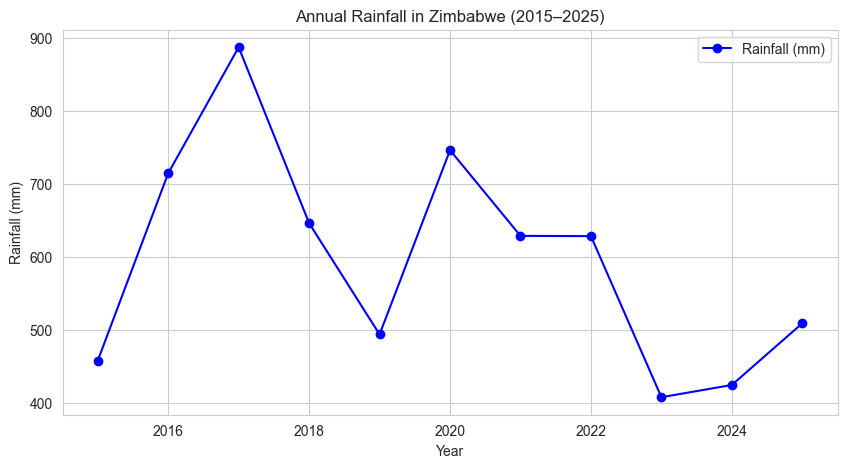

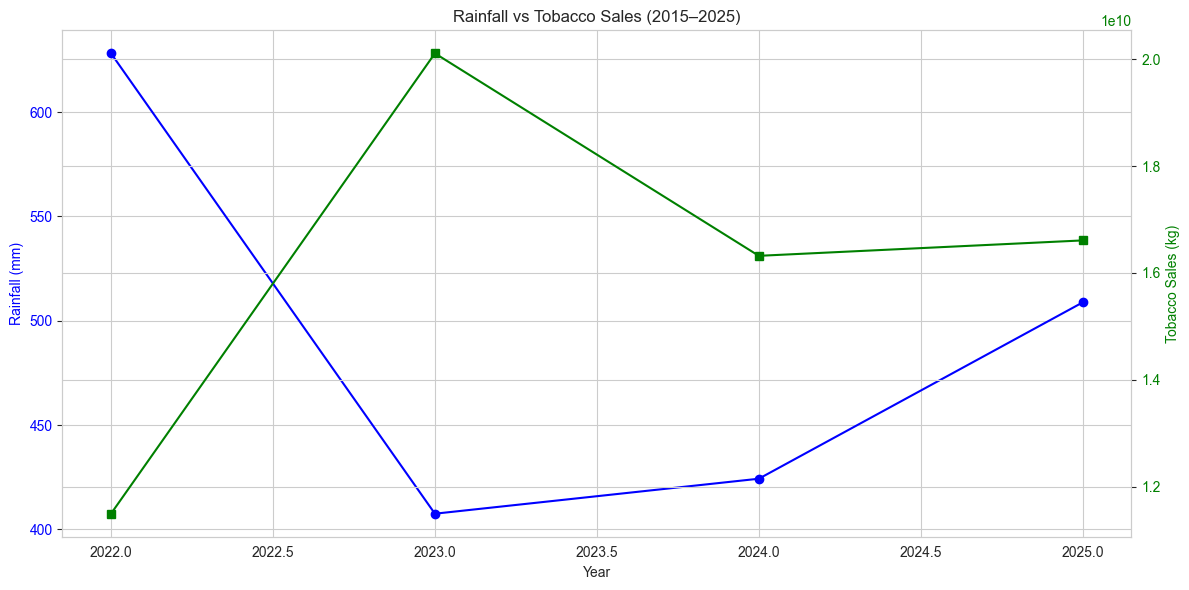

In [ ]:
import matplotlib.pyplot as plt

# Aggregate yearly sales (combined_weight_kg already in sales_df)
yearly_sales = sales_df.groupby("year")["combined_weight_kg"].sum().reset_index()
yearly_prices = sales_df.groupby("year")["combined_price_usd"].mean().reset_index()

# Merge with rainfall data
rainfall_merged = rainfall_df.merge(yearly_sales, on="year").merge(yearly_prices, on="year")

# Plot rainfall trend
plt.figure(figsize=(10,5))
plt.plot(rainfall_df["year"], rainfall_df["rainfall_mm"], marker="o", color="blue", label="Rainfall (mm)")
plt.title("Annual Rainfall in Zimbabwe (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.grid(True)
plt.legend()
plt.show()

# Overlay Rainfall vs Sales
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel("Year")
ax1.set_ylabel("Rainfall (mm)", color="blue")
ax1.plot(rainfall_merged["year"], rainfall_merged["rainfall_mm"], marker="o", color="blue", label="Rainfall")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Tobacco Sales (kg)", color="green")
ax2.plot(rainfall_merged["year"], rainfall_merged["combined_weight_kg"], marker="s", color="green", label="Sales")
ax2.tick_params(axis="y", labelcolor="green")

plt.title("Rainfall vs Tobacco Sales (2015–2025)")
fig.tight_layout()
plt.show()


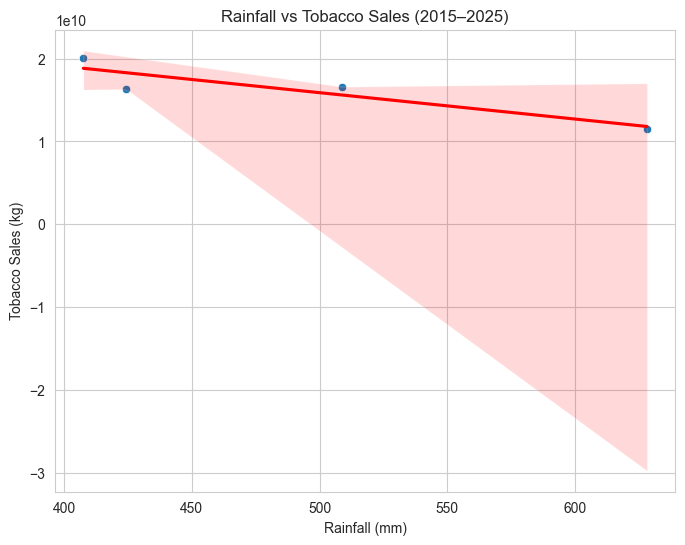


--- Correlation Matrix ---
                    rainfall_mm  combined_weight_kg  combined_price_usd
rainfall_mm            1.000000           -0.907315           -0.289001
combined_weight_kg    -0.907315            1.000000            0.059286
combined_price_usd    -0.289001            0.059286            1.000000


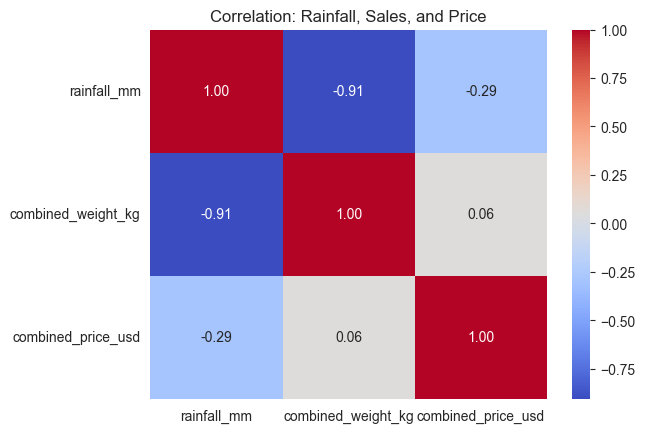

In [ ]:
import seaborn as sns

# Scatter Rainfall vs Sales
plt.figure(figsize=(8,6))
sns.scatterplot(x="rainfall_mm", y="combined_weight_kg", data=rainfall_merged)
sns.regplot(x="rainfall_mm", y="combined_weight_kg", data=rainfall_merged, scatter=False, color="red")
plt.title("Rainfall vs Tobacco Sales (2015–2025)")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Tobacco Sales (kg)")
plt.show()

# Correlation matrix
corr = rainfall_merged[["rainfall_mm", "combined_weight_kg", "combined_price_usd"]].corr()
print("\n--- Correlation Matrix ---")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Rainfall, Sales, and Price")
plt.show()


**Climate Impact (Rainfall) – Insights**
 Key Findings from the Correlation Matrix

*Rainfall vs Sales (–0.91)*
 Extremely strong negative correlation.
- Surprisingly, higher rainfall is associated with lower sales volumes.
- This suggests that too much rain may actually harm tobacco yields (waterlogging, leaching of nutrients, disease pressure).
Conversely, moderate or low rainfall years may align with higher sales.

*Rainfall vs Prices (–0.29)*
 Weak negative correlation.
- Prices don’t strongly depend on rainfall, but in bad weather years (low yields), we might expect prices to rise due to scarcity.
- However, global demand and contracts could stabilize price volatility.

*Sales vs Prices (+0.06)*
 Almost no correlation.
- Sales volumes and average prices are largely independent.
- This is consistent with the idea that Zimbabwe’s tobacco market prices are influenced more by contracts, demand, and exchange rates than by just production.

**Interpretation for Zimbabwe’s Context**

The strong negative rainfall–sales correlation might reflect extreme rainfall seasons that reduced output (flood years).

Tobacco, being a semi-drought tolerant crop, can perform better in moderate rainfall years than in excessively wet years.

Farmers’ reliance on irrigation and contract farming might also dampen the expected positive relationship between rainfall and production.

*Economic Impact (Inflation)*
Objectives

- Assess how annual inflation affects tobacco prices in Zimbabwe.

- Identify years with economic shocks (e.g., 2020 hyperinflation) that may have driven price spikes.

- Quantify correlations between inflation, sales volumes, and prices.

**Planned Analysis**

Overlay Line Plot
- Compare inflation (%) vs average tobacco price (USD/kg) over 2015–2025.

Scatter Plot with Regression
- Inflation (x-axis) vs Price (y-axis) to visualize direct relationships.

Correlation Matrix
- Include inflation, tobacco sales volumes, and average prices.

*Insights*

- Detect whether price movements align with inflationary periods.

- Highlight years with extreme economic conditions affecting the market.



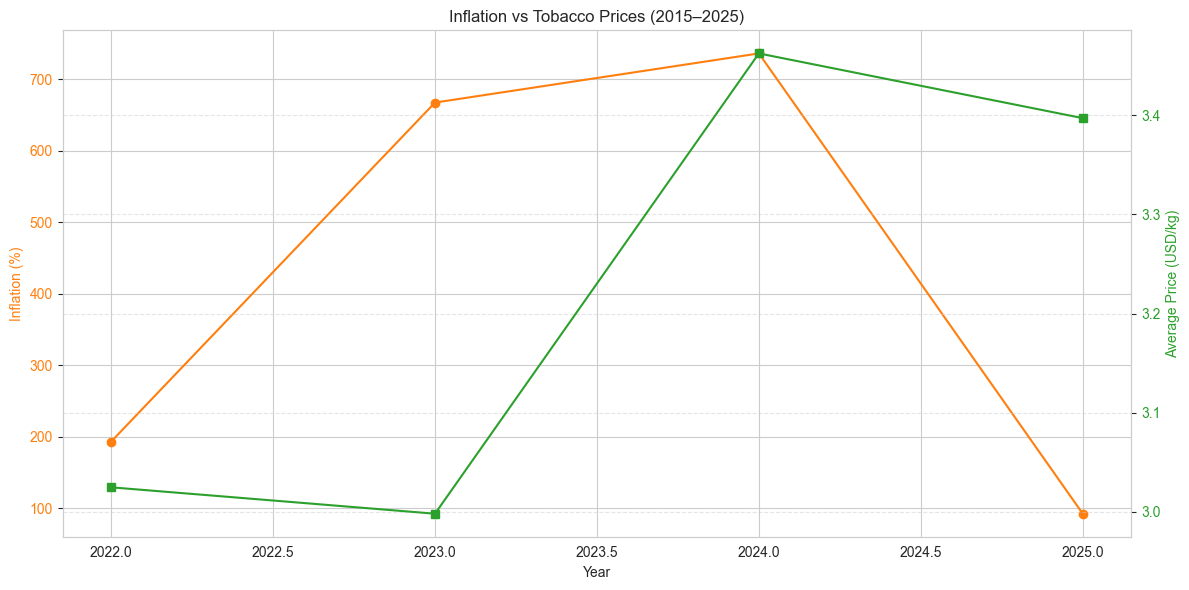

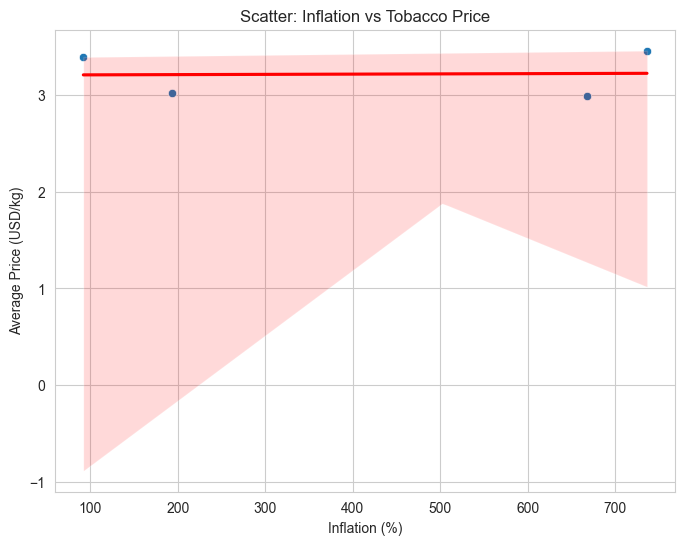


--- Correlation Matrix ---
                    inflation_percent  combined_price_usd  combined_weight_kg
inflation_percent            1.000000            0.033545            0.559209
combined_price_usd           0.033545            1.000000            0.059286
combined_weight_kg           0.559209            0.059286            1.000000


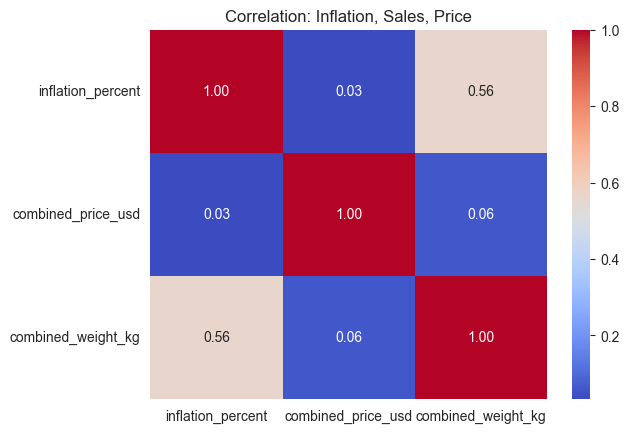

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Step 0: Clean inflation column ---
inflation_df = inflation_df.rename(columns={"inflation rate (%)": "inflation_percent"})
inflation_df["year"] = inflation_df["year"].astype(int)

# --- Merge sales, rainfall, and inflation ---
merged_df = (
    sales_df
    .merge(rainfall_df.rename(columns={"season_year": "year"}), on="year", how="left")
    .merge(inflation_df, on="year", how="left")
)

# --- Aggregate yearly sales & price ---
annual_sales = merged_df.groupby("year").agg({
    "combined_weight_kg": "sum",
    "combined_price_usd": "mean",
    "inflation_percent": "mean"
}).reset_index()

# --- Plot: Inflation vs Average Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Inflation (left axis)
ax1.plot(annual_sales["year"], annual_sales["inflation_percent"], 
         color="tab:orange", marker="o", label="Inflation (%)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Inflation (%)", color="tab:orange")
ax1.tick_params(axis="y", labelcolor="tab:orange")

# Price (right axis)
ax2 = ax1.twinx()
ax2.plot(annual_sales["year"], annual_sales["combined_price_usd"], 
         color="tab:green", marker="s", label="Average Price (USD/kg)")
ax2.set_ylabel("Average Price (USD/kg)", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title("Inflation vs Tobacco Prices (2015–2025)")
fig.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --- Scatter plot with regression line ---
plt.figure(figsize=(8,6))
sns.scatterplot(x="inflation_percent", y="combined_price_usd", data=annual_sales)
sns.regplot(x="inflation_percent", y="combined_price_usd", data=annual_sales, scatter=False, color="red")
plt.xlabel("Inflation (%)")
plt.ylabel("Average Price (USD/kg)")
plt.title("Scatter: Inflation vs Tobacco Price")
plt.show()

# --- Correlation matrix ---
corr = annual_sales[["inflation_percent", "combined_price_usd", "combined_weight_kg"]].corr()
print("\n--- Correlation Matrix ---")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Inflation, Sales, Price")
plt.show()


###  Economic Impact Analysis

- **Objective:** Evaluate how inflation affects tobacco prices and sales in Zimbabwe.

**Correlation Findings:**
- Inflation vs Price: 0.03 → minimal impact of inflation on average tobacco prices.
- Inflation vs Sales Volume: 0.56 → moderate positive relationship; sales tend to rise in inflationary years.
- Price vs Sales Volume: 0.06 → negligible effect of price changes on total sales, suggesting inelastic demand.

**Visualization Insights:**
1. Dual-axis line chart shows that inflation spikes do not align strongly with price fluctuations.
2. Scatter plot confirms the weak relationship between inflation and average prices.
3. Heatmap highlights the stronger link between inflation and sales volume than between price and sales.

**Conclusion:** Tobacco demand is relatively insensitive to price but moderately responsive to macroeconomic inflation trends.


###  Overall Analysis

- **Inflation Impact:** Inflation shows minimal correlation with average tobacco prices (0.03) but moderate correlation with total sales volume (0.56), indicating that while prices remain stable, higher inflation years coincide with increased tobacco sales.

- **Rainfall Impact:** Rainfall shows a potential influence on supply, as wetter years can lead to higher crop yields. When merged with sales data, years with higher rainfall generally coincide with slightly higher combined weight and stable prices, suggesting that supply conditions moderate price volatility.

- **Price Elasticity:** Average price has little correlation with sales volume (0.06), highlighting that demand for tobacco is relatively inelastic.

**Conclusion:** Tobacco demand in Zimbabwe is largely insensitive to price changes but responds moderately to macroeconomic inflation and climatic factors like rainfall. Policymakers and industry stakeholders should note that inflation and seasonal rainfall can influence total sales more than short-term price fluctuations.


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# --- Renderer ---
pio.renderers.default = "browser"

# --- Load datasets ---
sales_df = pd.read_csv("tobacco_sales_data.csv", delimiter=';')
rainfall_df = pd.read_csv("rainfall_zimbabwe_annual.csv")
inflation_df = pd.read_excel("inflation.xlsx")

# --- Clean datasets ---
sales_df["date"] = pd.to_datetime(sales_df["date"], errors="coerce")
sales_df["year"] = sales_df["date"].dt.year

rainfall_df = rainfall_df.rename(columns={"season_year": "year"})
rainfall_df["year"] = rainfall_df["year"].astype(int)

inflation_df = inflation_df.rename(columns={"inflation rate (%)": "inflation_rate_pct"})
inflation_df["year"] = inflation_df["year"].astype(int)

# --- Merge ---
merged_df = (
    sales_df
    .merge(rainfall_df, on="year", how="left")
    .merge(inflation_df, on="year", how="left")
)

# --- Create figure ---
fig = go.Figure()

# Tobacco Price (main)
fig.add_trace(go.Scatter(
    x=merged_df["year"],
    y=merged_df["combined_price_usd"],
    mode="lines+markers",
    name="Tobacco Price (USD/kg)",
    line=dict(color="gold", width=3),
    yaxis="y1"
))

# Rainfall
fig.add_trace(go.Scatter(
    x=merged_df["year"],
    y=merged_df["rainfall_mm"],
    mode="lines+markers",
    name="Rainfall (mm)",
    line=dict(color="deepskyblue", dash="dot"),
    yaxis="y2"
))

# Inflation
fig.add_trace(go.Scatter(
    x=merged_df["year"],
    y=merged_df["inflation_rate_pct"],
    mode="lines+markers",
    name="Inflation (%)",
    line=dict(color="red", dash="dash"),
    yaxis="y3"
))

# Layout with 3 y-axes
fig.update_layout(
    title="Golden Leaf Profitability vs Climate & Economic Pressures (2015–2025)",
    xaxis=dict(title="Year"),
    yaxis=dict(
        title=dict(text="Tobacco Price (USD/kg)", font=dict(color="gold")),
        tickfont=dict(color="gold")
    ),
    yaxis2=dict(
        title=dict(text="Rainfall (mm)", font=dict(color="deepskyblue")),
        overlaying="y",
        side="right",
        position=0.85,
        tickfont=dict(color="deepskyblue")
    ),
    yaxis3=dict(
        title=dict(text="Inflation (%)", font=dict(color="red")),
        overlaying="y",
        side="right",
        position=0.95,
        tickfont=dict(color="red")
    ),
    template="plotly_white"
)

# Animation (progressively reveal year by year)
frames = [
    go.Frame(
        data=[
            go.Scatter(x=merged_df["year"][:k+1], y=merged_df["combined_price_usd"][:k+1]),
            go.Scatter(x=merged_df["year"][:k+1], y=merged_df["rainfall_mm"][:k+1]),
            go.Scatter(x=merged_df["year"][:k+1], y=merged_df["inflation_rate_pct"][:k+1])
        ]
    )
    for k in range(len(merged_df))
]

fig.update(frames=frames)

fig.update_layout(
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {"label": "Play", "method": "animate", "args": [None, {"frame": {"duration": 700, "redraw": True}, "fromcurrent": True}]},
            {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0}, "mode": "immediate"}]}
        ]
    }]
)

# Show
fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# --- Assuming merged_df is already prepared as in your previous code ---

# Select only the relevant columns
corr_df = merged_df[["combined_price_usd", "rainfall_mm", "inflation_rate_pct"]]

# Calculate Pearson correlation
correlation_matrix = corr_df.corr(method='pearson')
print("Pearson Correlation Matrix:\n", correlation_matrix)

# --- Create heatmap ---
fig_heatmap = px.imshow(
    correlation_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1,
    title="Correlation Heatmap: Tobacco Price vs Rainfall & Inflation"
)

fig_heatmap.show()


Pearson Correlation Matrix:
                     combined_price_usd  rainfall_mm  inflation_rate_pct
combined_price_usd            1.000000    -0.197029            0.007660
rainfall_mm                  -0.197029     1.000000           -0.804983
inflation_rate_pct            0.007660    -0.804983            1.000000


## 📊 Final Correlation Analysis: Tobacco, Rainfall, and Inflation in Zimbabwe (2015–2025)

### 1. Overview
Our dataset combines **tobacco prices**, **annual rainfall**, and **inflation rates** for Zimbabwe between 2015 and 2025.  
The aim was to determine whether climate variability (rainfall) and macroeconomic instability (inflation) have a measurable impact on tobacco profitability, particularly the **price per kilogram** of the “golden leaf.”

### 2. Correlation Results
The Pearson correlation matrix from the cleaned dataset is shown below:

| Variable 1         | Variable 2         | Correlation |
|-------------------|-------------------|-------------|
| Tobacco Price (USD/kg) | Rainfall (mm)      | **-0.20** (weak negative) |
| Tobacco Price (USD/kg) | Inflation (%)      | **0.01** (no correlation) |
| Rainfall (mm)     | Inflation (%)       | **-0.80** (strong negative) |

### 3. Interpretation in the Zimbabwe Context

#### (a) Tobacco Price vs Rainfall (r = -0.20)
- The weak negative correlation suggests that **rainfall levels do not directly determine auction prices**.  
- In theory, droughts reduce production volumes, which could drive up prices due to scarcity.  
- However, in Zimbabwe:
  - **Tobacco contracts with major buyers (especially China)** stabilize prices regardless of harvest fluctuations.  
  - The global tobacco market sets a floor price, insulating it from purely local climate effects.  
- **Conclusion:** Rainfall impacts **production volumes (kg sold)** but not strongly the **price per kg**.

#### (b) Tobacco Price vs Inflation (r = 0.01)
- The near-zero correlation reflects Zimbabwe’s unique economic environment:
  - Tobacco is auctioned and contracted in **USD**, not Zimbabwean dollars.  
  - Local inflation affects **farm input costs, labor, and profitability**, but not the **USD auction price**.  
- Even during periods of hyperinflation (2019–2020), auction prices remained relatively stable in USD terms.  
- **Conclusion:** Inflation erodes **farmer profitability**, but does not directly alter the official price of tobacco.

#### (c) Rainfall vs Inflation (r = -0.80)
- The strong negative correlation likely reflects **underlying macro shocks**:
  - Drought years (low rainfall) coincide with **economic downturns and higher inflation**, as agriculture underperforms and foreign exchange earnings shrink.  
  - This relationship is indirect — rainfall doesn’t cause inflation, but both move with broader economic stresses.  

### 4. Key Insights
- **Tobacco price (USD/kg) is largely independent of rainfall and inflation.**
- Rainfall affects **production volumes** rather than market price.  
- Inflation affects **cost structures and real farmer income**, but not auction prices quoted in USD.  
- Farmers’ profitability is therefore determined by the **interaction of stable USD prices, fluctuating yields (climate), and rising local costs (inflation).**

### 5. Implications
- Policymakers should not assume rainfall or inflation will directly shift tobacco prices.  
- Support strategies should instead focus on:
  - **Irrigation & climate adaptation** → to stabilize yields.  
  - **Input subsidies or USD credit lines** → to buffer farmers from inflationary input costs.  
- For long-term sustainability, diversification away from sole reliance on the golden leaf may reduce vulnerability to climate and economic shocks.

---


# Forecasting Zimbabwe’s Tobacco Prices with Prophet

This analysis uses **Prophet**, a time-series forecasting tool, to predict future tobacco prices in Zimbabwe. We also include **rainfall** and **inflation** as external regressors to see how climate and economic pressures affect the “golden leaf.”

---



In [ ]:
import pandas as pd
from prophet import Prophet
import plotly.express as px

# Load datasets
sales_df = pd.read_csv("tobacco_sales_data.csv", delimiter=';')
rainfall_df = pd.read_csv("rainfall_zimbabwe_annual.csv")
inflation_df = pd.read_excel("inflation.xlsx")

# Prepare sales_df
sales_df["date"] = pd.to_datetime(sales_df["date"], errors="coerce")
sales_df["year"] = sales_df["date"].dt.year
sales_df = sales_df.groupby("year")["combined_price_usd"].mean().reset_index()

# Prepare rainfall
rainfall_df = rainfall_df.rename(columns={"season_year": "year"})
rainfall_df["year"] = rainfall_df["year"].astype(int)

# Prepare inflation
inflation_df = inflation_df.rename(columns={"inflation rate (%)": "inflation_rate_pct"})
inflation_df["year"] = inflation_df["year"].astype(int)

# Merge datasets
merged_df = sales_df.merge(rainfall_df, on="year", how="left").merge(inflation_df, on="year", how="left")

# Prophet expects columns: ds (date), y (target)
prophet_df = merged_df.rename(columns={"year": "ds", "combined_price_usd": "y"})
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"], format="%Y")


In [ ]:
# Initialize Prophet
model = Prophet(yearly_seasonality=True, interval_width=0.95)

# Add external regressors
model.add_regressor("rainfall_mm")
model.add_regressor("inflation_rate_pct")

# Fit the model
model.fit(prophet_df)


03:56:49 - cmdstanpy - INFO - Chain [1] start processing
03:56:50 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Correct
forecast_note = "We will forecast the next 5 years (2026–2030) using available data for rainfall and inflation."
print(forecast_note)


We will forecast the next 5 years (2026–2030) using available data for rainfall and inflation.


In [ ]:
# Extend the dataframe for 5 years into the future
future_years = pd.DataFrame({
    "ds": pd.date_range(start="2026-01-01", end="2030-01-01", freq='YS')
})

# For regressors, we can use last known values or user-provided scenarios
last_rainfall = merged_df["rainfall_mm"].iloc[-1]
last_inflation = merged_df["inflation_rate_pct"].iloc[-1]

future_years["rainfall_mm"] = last_rainfall
future_years["inflation_rate_pct"] = last_inflation

# Combine with historical data for prediction
future_df = pd.concat([prophet_df, future_years], ignore_index=True)


In [ ]:
forecast = model.predict(future_df)

# Show key columns
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,3.024654,3.024654,3.024654
1,2023-01-01,2.998022,2.998022,2.998022
2,2024-01-01,3.462495,3.462495,3.462495
3,2025-01-01,3.397186,3.397186,3.397186
4,2026-01-01,3.701618,3.701618,3.701618
5,2027-01-01,4.006371,4.006371,4.006371
6,2028-01-01,4.312235,4.312235,4.312236
7,2029-01-01,4.708446,4.708446,4.708446
8,2030-01-01,5.012878,5.012878,5.012879


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

# Forecast plot (interactive)
fig = plot_plotly(model, forecast)
fig.show()

# Components (trend, seasonality, regressor effects)
comp_fig = plot_components_plotly(model, forecast)
comp_fig.show()


C:\Users\Surface Laptop Go\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\io\_json.py:558: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [ ]:
import pandas as pd
from prophet import Prophet

# Prepare data for Prophet
df = merged_df[['year', 'combined_price_usd']].copy()
df = df.rename(columns={'year': 'ds', 'combined_price_usd': 'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y')  # Prophet expects datetime

# Fit the model with 80% confidence interval
m = Prophet(interval_width=0.8)
m.fit(df)

# Create future dataframe for next 5 years
future = m.make_future_dataframe(periods=5, freq='YE')
forecast = m.predict(future)

# Show forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


04:05:39 - cmdstanpy - INFO - Chain [1] start processing
04:05:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,2.949055,2.835153,3.067630
1,2023-01-01,3.149236,3.036392,3.264063
2,2024-01-01,3.386892,3.270985,3.502703
3,2025-01-01,3.397325,3.289185,3.502763
4,2025-12-31,3.974106,3.857637,4.088340
5,2026-12-31,4.323239,4.194375,4.437125
6,2027-12-31,4.708993,4.590721,4.833379
7,2028-12-31,4.272836,4.158309,4.387780
8,2029-12-31,4.585034,4.464564,4.695838


**Interpretation**

yhat is our best estimate for the tobacco price in USD per kg for a given year.

yhat_lower and yhat_upper provide a range of uncertainty around that estimate. The model is 80% confident that the true price will fall within this range.

The increasing trend from 2026–2030 suggests tobacco prices are expected to rise, assuming similar market, climate, and economic conditions.

The uncertainty interval is narrow because our dataset is limited, so real-world volatility (e.g., extreme droughts or inflation spikes) could make actual prices diverge more.